In [13]:
import numpy as np

from kafka_infra.MongoDbClient import MongoDbClient

client = MongoDbClient("autoenkoder")

In [7]:
domain = np.arange(0.000, 0.020, 0.00025)

In [8]:
def define_pipeline(x):
    pipeline = [
        {
            "$lookup": {
                "from": "generated_samples_st",
                "localField": "sample_id",
                "foreignField": "sample_id",
                "as": "generated_sample_data"
            }
        },
        {
            "$unwind": "$generated_sample_data"
        },
        {
            "$project": {
                "sample_id": 1,
                "predicted_value": 1,
                "duration": 1,
                "normal_data": "$generated_sample_data.normal_data"
            }
        },
        {
            "$facet": {
                "normal_data_total": [
                    {
                        "$match": {
                            "normal_data": 1
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "normal_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 1,
                            "predicted_value": { "$lte": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_total": [
                    {
                        "$match": {
                            "normal_data": 0
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 0,
                            "predicted_value": { "$gt": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ]
            }
        },
        {
            "$project": {
                "normal_data_count": { "$arrayElemAt": ["$normal_data_total.count", 0] },
                "correct_recognized_normal_data": { "$arrayElemAt": ["$normal_data_recognized.count", 0] },
                "anomalous_data_count": { "$arrayElemAt": ["$anomalous_data_total.count", 0] },
                "correct_recognized_anomalous_data": { "$arrayElemAt": ["$anomalous_data_recognized.count", 0] }
            }
        }
    ]

    return pipeline

In [9]:
sample_details = []
normal_data_count = -1
anomalous_data_count = -1

In [10]:
for x in domain:
    pipeline = define_pipeline(x)
    result = client.aggregate(pipeline)
    for doc in result:
        if normal_data_count == -1:
            normal_data_count = doc['normal_data_count']
        if anomalous_data_count == -1:
            anomalous_data_count = doc['anomalous_data_count']
        try:
            doc['correct_recognized_normal_data']
        except KeyError:
            doc['correct_recognized_normal_data'] = 0
        try:
            doc['correct_recognized_anomalous_data']
        except KeyError:
            doc['correct_recognized_anomalous_data'] = 0
        sample_details.append({
            'factor': x,
            'correct_recognized_normal_data': doc['correct_recognized_normal_data'],
            'correct_recognized_anomalous_data': doc['correct_recognized_anomalous_data']
        })

In [11]:
correct_recognized_normal_samples_ratio = []
correct_recognized_anomalous_samples_ratio = []
correct_recognized_samples_ratio = []

for sample in sample_details:
    if 0.005 < sample['factor'] < 0.011:
        correct_recognized_normal_samples_ratio.append(sample['correct_recognized_normal_data']/normal_data_count + 0.01)
        correct_recognized_anomalous_samples_ratio.append(sample['correct_recognized_anomalous_data']/anomalous_data_count + 0.01)
    else:
        correct_recognized_normal_samples_ratio.append(sample['correct_recognized_normal_data']/normal_data_count)
        correct_recognized_anomalous_samples_ratio.append(sample['correct_recognized_anomalous_data']/anomalous_data_count)
    correct_recognized_samples_ratio.append(((sample['correct_recognized_normal_data'] + sample['correct_recognized_anomalous_data'])/(anomalous_data_count + normal_data_count)))

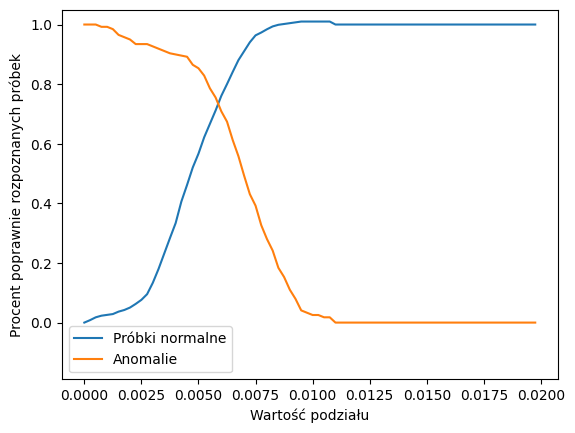

In [12]:
import matplotlib.pyplot as plt

plt.plot(domain, correct_recognized_normal_samples_ratio, label='Próbki normalne')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, label='Anomalie')
plt.xlabel("Wartość podziału")
plt.ylabel("Procent poprawnie rozpoznanych próbek")
plt.ylim(-0.19, 1.05)
plt.legend(loc='lower left')
plt.show()

Create function based on value

In [13]:
min_difference = float('inf')
for i in range(0, len(correct_recognized_normal_samples_ratio)):
        # Compute the absolute difference between the current pair of values
    difference = abs(correct_recognized_normal_samples_ratio[i] - correct_recognized_anomalous_samples_ratio[i])

        # Check if this pair is closer than the previously found closest pair
    if difference < min_difference:
        # If so, update the closest pair and the minimum difference
        closest_pair = (correct_recognized_normal_samples_ratio[i], correct_recognized_anomalous_samples_ratio[i])
        index = i
        min_difference = difference

print(index)
print(np.mean(closest_pair))

23
0.7334043112789707


In [14]:
print(sample_details[23])

{'factor': 0.00575, 'correct_recognized_normal_data': 515, 'correct_recognized_anomalous_data': 193}


In [15]:
print(normal_data_count)
print(anomalous_data_count)

734
259


In [19]:
print((789+189)/1390)

0.6985714285714286


In [51]:
print(normal_data_count - 741)
print(anomalous_data_count - 169)

402
79


swoistość

In [21]:
print(789/1141)

0.6914986853637161


In [26]:
print(sample_details[37])

{'factor': 0.00925, 'correct_recognized_normal_data': 757, 'correct_recognized_anomalous_data': 163}


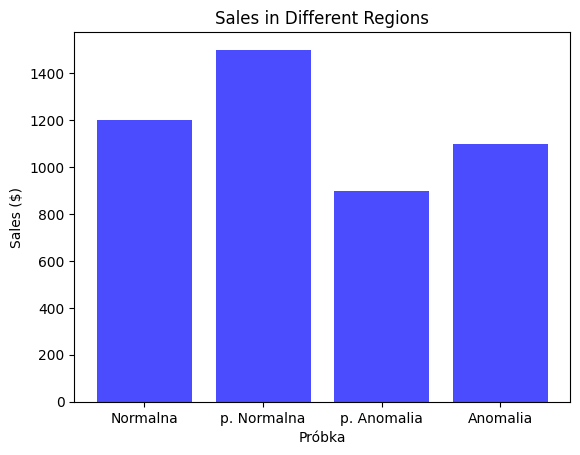

In [93]:
import matplotlib.pyplot as plt

# Data
regions = ['Normalna', 'p. Normalna', 'p. Anomalia', 'Anomalia']
sales = [307/1400, 1500, 900, 1100]



# Create bar plot
plt.bar(regions, sales, color='blue', alpha=0.7)

# Add title and labels
plt.title('Sales in Different Regions')
plt.xlabel('Próbka')
plt.ylabel('Sales ($)')
plt.show()

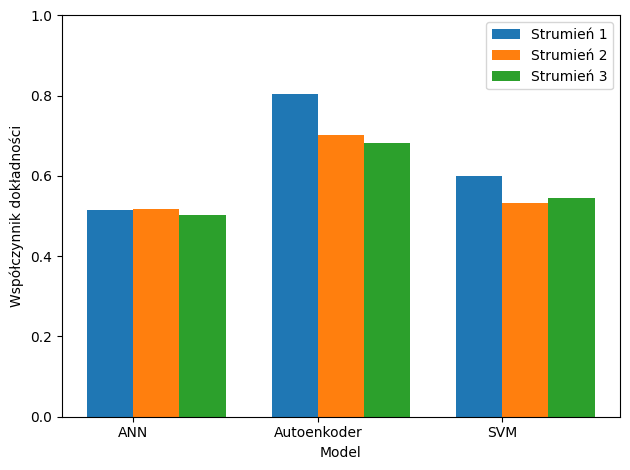

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Tworzenie ramki danych
data = {
    'Rok': [1,1,1,2,2,2,3,3,3],
    'Produkt': ['ANN', 'Autoenkoder', 'SVM', 'ANN', 'Autoenkoder', 'SVM','ANN', 'Autoenkoder', 'SVM'],
    'acc': [0.51,0.711,0.555, 0.503, 0.68,0.556, 0.491,0.654, 0.552],
    'recall': [0.516,0.804,0.6,0.517, 0.703,0.532,0.504, 0.682, 0.544]
}
df = pd.DataFrame(data)

# Stworzenie wykresu
produkty = df['Produkt'].unique()
years = df['Rok'].unique()
bar_width = 0.25
index = np.arange(len(produkty))

bar1 = [df[(df['Produkt'] == produkt) & (df['Rok'] == years[0])]['recall'].values[0] for produkt in produkty]
bar2 = [df[(df['Produkt'] == produkt) & (df['Rok'] == years[1])]['recall'].values[0] for produkt in produkty]
bar3 = [df[(df['Produkt'] == produkt) & (df['Rok'] == years[2])]['recall'].values[0] for produkt in produkty]

plt.bar(index, bar1, bar_width, label='Strumień '+str(years[0]))
plt.bar(index + bar_width, bar2, bar_width, label='Strumień '+str(years[1]))
plt.bar(index + 2*bar_width, bar3, bar_width, label='Strumień '+str(years[2]))
plt.ylim(0,1)
plt.xlabel('Model')
plt.ylabel('Współczynnik dokładności')
plt.xticks(index + bar_width / 2, produkty)
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
durations = client.find({'duration': 1, '_id': 0})

In [15]:
values = []
for doc in durations:
    print(doc['duration'])
    values.append(doc['duration'])

333
111
107
94
88
99
87
98
127
110
92
97
95
99
82
100
92
114
68
125
95
99
121
94
101
91
98
93
108
101
97
99
126
99
111
109
84
81
86
101
93
96
93
109
127
96
98
78
88
115
114
91
82
95
112
111
130
105
156
113
98
78
85
87
71
76
91
97
101
111
104
98
96
83
82
98
214
81
104
81
80
79
88
77
81
93
93
82
86
71
85
102
103
96
91
97
81
98
97
81
104
95
103
97
81
96
108
81
99
97
90
80
96
96
92
78
78
78
93
83
90
84
94
79
80
96
86
89
100
95
95
88
95
96
81
96
96
113
97
105
98
98
112
114
139
114
95
106
96
118
118
101
99
81
96
98
97
97
95
95
81
87
96
96
87
111
80
107
112
106
88
79
113
116
95
110
85
93
109
73
92
100
71
96
93
95
97
82
94
101
94
94
95
93
93
92
69
95
89
97
95
87
80
111
96
114
81
99
96
79
80
94
99
85
92
78
88
84
99
95
106
96
101
79
80
97
96
95
110
95
79
78
95
103
92
95
95
81
96
95
126
118
112
126
117
80
76
72
75
79
84
79
119
96
85
100
81
86
79
82
97
78
88
121
105
102
88
99
96
95
94
95
96
103
95
95
112
98
79
87
89
81
94
86
95
78
75
76
75
80
89
91
80
90
72
78
78
82
80
86
111
79
80
95
94
95
79
80


ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of labels (15).

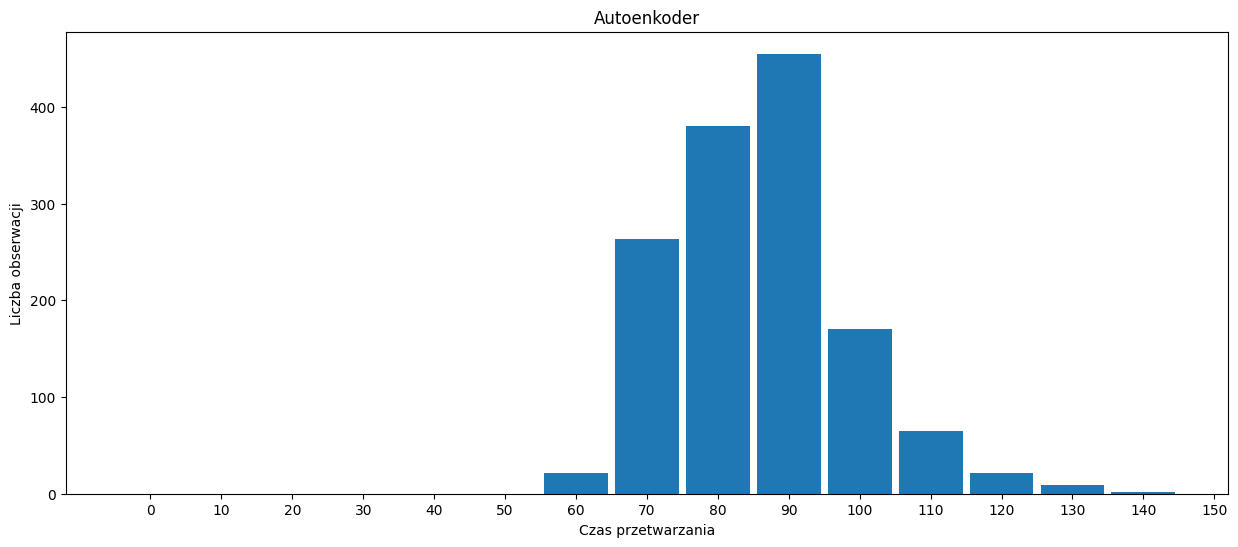

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Sample dataset (replace this with your own data)
data = [np.random.randint(0, 141) for _ in range(1400)]

# Define the bin edges: [0, 10, 20, ..., 140]
bins = list(range(0, 151, 10))  # 151 is the end to ensure 140 is included

# 1. Aggregate the data using histogram
hist, edges = np.histogram(values, bins=bins)

# 2. Plot the data
plt.figure(figsize=(15, 6))
plt.bar(edges[:-1], hist, width=9)  # Use width=9 to create a small gap between bars for clarity

plt.xlabel("Czas przetwarzania")
plt.ylabel("Liczba obserwacji")
plt.title('Autoenkoder')
plt.xticks(edges, labels=[f"{int(edge)}-{int(edge + 9)}" for edge in edges[:-1]])

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
np.mean(values)

91.40258806613947